<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/V15_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1500
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp


class ArtificialHandwrittingObject:
    
    def __init__(self, name, img):
        self.name = name
        self.image = img

class ArtificialHandwritting:
    
    def __init__(self, datasetDir, scale, image_width, image_height, encode_word):
        self.scale = scale
        self.height = image_height
        self.width = image_width
        self.datasetDirectory = datasetDir
        self.data = {}
        self.initOffsets()
        self.encode_word = encode_word
        
        for f_name in os.listdir(datasetDir):
            if not f_name.endswith(".xml"):
                continue
            full_path = datasetDir + f_name
            print(full_path)
            self.process_xml(full_path)
            
    def initOffsets(self):
        self.offsets = {
            'a': 0,
            'b': -0.1,
            'c': 0,
            'd': 0,
            'e': 0,
            'f': -0.2,
            'g': +0.3,
            'h': 0,
            'i': -0.15,
            'j': +0.2,
            'k': 0,
            'l': -0.15,
            'm': 0,
            'n': 0,
            'o': 0,
            'p': 0,
            'q': +0.2,
            'r': 0,
            's': 0,
            't': -0.2,
            'u': 0,
            'v': 0,
            'w': 0,
            'x': 0,
            'y': +0.2,
            'z': 0,
        }
        
        
        
    def getValue(self, node, name):
        v  = node.getElementsByTagName(name) 
        if len(v) != 1:
            raise Exception()
        v = v[0].firstChild.data
        return v
    
    def make_random_batch(self, word_len, rand_x):
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        texts = []
        datas = []
        #data = torch.FloatTensor(batch_size, self.image_height, self.image_width)
        for batch_idx in range(0, batch_size):
          w = ""
          for i in range(0, word_len):
            s_idx = floor(random()*len(alphabet))
            s = alphabet[s_idx]
            w += s
          x = floor(random()*rand_x)
          d, _ = self.make_word(w, x)
          d = d = torch.as_tensor(d)#.unsqueeze(0)
          
          datas.append(d)
          w = self.encode_word(w)
          texts.append(w)
        t = torch.stack(texts)
        data = torch.stack(datas, dim=0)
        return data, t
          
       
    def make_word(self, word, x_start):
        center = self.height*0.5
        result = sp.ones([self.height, self.width], dtype="float32")
        candidates = []
        for k in self.data.keys():
            d = self.data[k]
            flag = True
            for s in word:
                if s not in d:
                    flag = False
                    break
            if flag:
                candidates.append(k)
        idx = floor(random()*len(candidates))
        if (len(candidates) == 0):
          print("Bad word: " + word)
          raise Exception()
        
        img_file = candidates[idx]
        page = self.data[img_file]
        x = x_start
        for s in word:
            s_idx = floor(len(page[s])*random())
            obj_im = page[s][s_idx].image
            c = 0.5*obj_im.shape[0]
            dy = 0 + floor(center - c + obj_im.shape[0]*(self.offsets[s]+random()*0.05))#+random()*0.05))
            #print(dy)
            #print(obj_im.dtype)
            result[dy: dy + obj_im.shape[0], x: x+obj_im.shape[1]] = obj_im
            x += obj_im.shape[1]
        return result, img_file  
      
            
    def process_xml(self, f_path):
        
        xml_file = minidom.parse(f_path)
        #xml_file.normalize()
        annotation = xml_file.getElementsByTagName('annotation')
        if len(annotation) != 1:
            raise Exception()
        annotation = annotation[0]
        img_name = self.getValue(annotation, 'filename')
        image_file = self.datasetDirectory + img_name
        img = cv2.imread(image_file, 0)
        print(image_file)
        objects = annotation.getElementsByTagName('object')
        #print(len(objects))
        content = {}
        for obj in objects:
            name  = self.getValue(obj, 'name')
            if name not in content:
                content[name] = []
            x_min = int(self.getValue(obj, 'xmin'))
            y_min = int(self.getValue(obj, 'ymin'))
            x_max = int(self.getValue(obj, 'xmax'))
            y_max = int(self.getValue(obj, 'ymax'))
            obj_im = img[y_min: y_max, x_min: x_max]
            s = self.scale
            sh = obj_im.shape
            obj_im = cv2.resize(obj_im, (floor(sh[1]*s), floor(sh[0]*s)), cv2.INTER_LANCZOS4)
            if obj_im.shape[0] > self.height:
                continue
            obj_im = sp.float32(obj_im)    
            obj_im = (obj_im - obj_im.min())/(obj_im.max() - obj_im.min())
            handwr_obj = ArtificialHandwrittingObject(name, obj_im)
            content[name].append(handwr_obj)
        if img_name in self.data:
            raise Exception()
        self.data[img_name] = content
        

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords

pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
artificial_data = ArtificialHandwritting("./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png


In [0]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

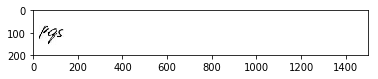

torch.Size([100, 200, 1500])

In [0]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 2, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([2, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 8, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([8, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, (3, 1)], padding=0, stride=(2, 1), bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, (4, 1)], padding=0, stride=(2, 1), bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = h.squeeze(2)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 92])

In [0]:
class SimpleDecoder(nn.Module):
  def __init__(self, batch_size, ntoken, encoded_width=92, encoded_height=64):
    super(SimpleDecoder, self).__init__()
    self.encoded_width = encoded_width
    self.encoded_height = encoded_height
    features_size = encoded_height*encoded_width 
    self.lstm_size = 512
    self.lstm_layers = 3
    self.rnn = nn.GRU(features_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
    self.decoder = nn.Linear(self.lstm_size, ntoken)
    self.attention = FullyConnectedX([self.lstm_size*self.lstm_layers + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2, self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
    self.attention_weights = None
    
  def forward(self, x, hidden=None):
    if hidden is not None:
      hidden_m = hidden.permute(1, 0, 2)
      hidden_m = hidden_m.flatten(start_dim=1)
      x_m = x.squeeze(0)
      x_m = x_m.flatten(start_dim=1)
      attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
      self.attention_weights = self.attention(attention_inp)
      self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
      self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
      x = x * self.attention_weights
    x = x.flatten(start_dim=-2)
    x, hidden = self.rnn(x, hidden)
    x = self.decoder(x)
    return x, hidden
    
simpleDecoder = SimpleDecoder(batch_size, len(train_set.codes)).to(device)    

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
def generate(c, orig_data, target):
  num_samples = 1
  hidden = None
  test_inp = c.unsqueeze(0)
  results = []
  for ex_num in range(0, num_samples):
    results.append("")
  for i in range(0, 5):
    out, hidden = simpleDecoder(test_inp, hidden)
    _, idx = out.topk(1, dim=2)
    for ex_num in range(0, num_samples):
      ii = idx[0, ex_num, 0]
      results[ex_num] += test_set.alphabet[ii.item()]
  for ex_num in range(0, num_samples):
    plt.imshow(orig_data[ex_num].cpu(), cmap="gray")
    plt.show()
    print(test_set.decode_word(target[ex_num, :]) + " -> " + results[ex_num])
    

In [0]:
#generate(c, data, target)

In [0]:
#loss = criterion(d, t)

In [0]:
enc_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
dec_optimizer = optim.Adam(simpleDecoder.parameters(), lr=1e-4, weight_decay=0.00005)


def train(epoch):
  print("Epoch %d"% epoch)
  int_loss = 0
  word_size = 5
  batch_idx = 0
  while True:
    if batch_idx > 500:
      break
    data, target = artificial_data.make_random_batch(word_size, 200)
#     print(data.shape)
#     print(target.shape)
    data = data.unsqueeze(1).to(device)
    target = target.to(device)
    c = encoder(data)
    inp = c.unsqueeze(0)
    
    hidden = None
    loss = 0
    for i in range(0, word_size):
      dec, hidden = simpleDecoder(inp, hidden)
      dec = dec.squeeze(0)
      loss += criterion(dec, target[:, i])
      
    if batch_idx % 50 == 0:
      print("Batch %d Loss %f" % (batch_idx, loss.item()))
    int_loss += loss.item()  
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    batch_idx += 1
  print("Epoch loss %f", int_loss/batch_idx)

In [0]:
def test():
  print("Testing...")
  word_size = 5
  batch_idx = 0
  while True:
    if batch_idx > 100:
      break
    data, target = artificial_data.make_random_batch(word_size, 5)
    orig_data = data
    data = data.unsqueeze(1).to(device)
    target = target.to(device)
    c = encoder(data)
    inp = c.unsqueeze(0)
    inp = inp.repeat(word_size, 1, 1, 1)
    dec, _ = simpleDecoder(inp)
    d = dec.flatten(end_dim=1)
    t = target.flatten()
    loss = criterion(d, t)
    if batch_idx % 30 == 0:
      print("Batch %d Loss %f" % (batch_idx, loss.item()))
      results = generate(c, orig_data, target)
    batch_idx += 1
  
        

In [0]:
def __train(epoch):
  print("Epoch %d"% epoch)
  int_loss = 0
  word_size = 5
  batch_idx = 0
  while True:
    if batch_idx > 1000*100:
      break
    data, target = artificial_data.make_random_batch(word_size, 5)
#     print(data.shape)
#     print(target.shape)
    data = data.unsqueeze(1).to(device)
    target = target.to(device)
    c = encoder(data)
    inp = c.unsqueeze(0)
    inp = inp.repeat(word_size, 1, 1, 1)
    dec, _ = simpleDecoder(inp)
#     d = dec.flatten(end_dim=1)
#     t = target.flatten()
    d = dec.view(-1, len(train_set.codes))
    t = target.view(-1)
    

    loss = criterion(d, t)
    int_loss += loss.item()
    if batch_idx % 200*100 == 0:
      print("Batch %d Loss %f" % (batch_idx, loss.item()))
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    batch_idx += 1
  print("Epoch loss %f", int_loss/batch_idx)

Testing...
Batch 0 Loss 4.400033


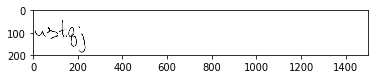

ustqj -> Zmmmm
Batch 30 Loss 4.399867


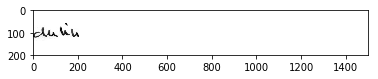

dklih -> mmmlm
Batch 60 Loss 4.398282


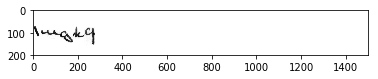

lmgkq -> mllmm
Batch 90 Loss 4.399463


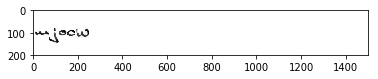

mjoow -> mmmmm


In [0]:
test()

Epoch 0
Batch 0 Loss 21.983858
Batch 50 Loss 16.696886
Batch 100 Loss 17.530706
Batch 150 Loss 18.877167
Batch 200 Loss 21.552753
Batch 250 Loss 22.651007
Batch 300 Loss 26.811281
Batch 350 Loss 27.170958
Batch 400 Loss 27.170660
Batch 450 Loss 29.718861
Batch 500 Loss 34.498482
Epoch loss %f 23.927202068641037
Testing...
Batch 0 Loss 7.196653


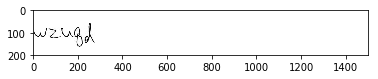

wzuqd -> sssss
Batch 30 Loss 6.739436


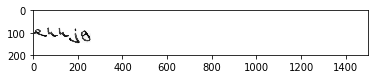

ekkjg -> sssss
Batch 60 Loss 7.172513


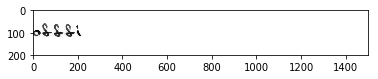

offfi -> sssss
Batch 90 Loss 7.224006


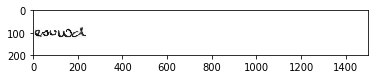

esvwd -> sssss
Epoch 1
Batch 0 Loss 36.004128
Batch 50 Loss 41.240196
Batch 100 Loss 39.658039
Batch 150 Loss 28.608196
Batch 200 Loss 24.603521
Batch 250 Loss 33.602699
Batch 300 Loss 37.634979
Batch 350 Loss 43.411858
Batch 400 Loss 46.283257
Batch 450 Loss 39.992439
Batch 500 Loss 45.363232
Epoch loss %f 37.47802296179735
Testing...
Batch 0 Loss 9.154989


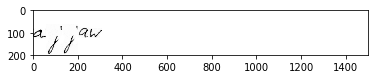

ajjaw -> xxxxx
Batch 30 Loss 9.005460


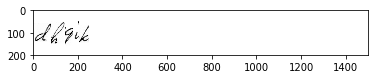

dhqik -> xxxxx
Batch 60 Loss 8.907621


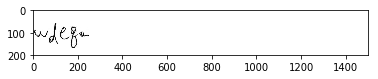

wdeqa -> xxxxx
Batch 90 Loss 8.783598


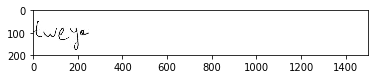

tweya -> xxxxx
Epoch 2
Batch 0 Loss 45.670273
Batch 50 Loss 46.589977
Batch 100 Loss 41.893280
Batch 150 Loss 40.806721
Batch 200 Loss 40.135071
Batch 250 Loss 47.535206
Batch 300 Loss 45.285412
Batch 350 Loss 52.421066
Batch 400 Loss 53.278645
Batch 450 Loss 57.802994
Batch 500 Loss 63.299294
Epoch loss %f 48.71368859723181
Testing...
Batch 0 Loss 12.268523


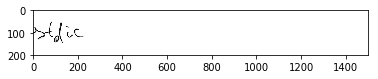

stdic -> eeeee
Batch 30 Loss 12.888303


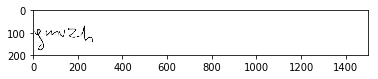

gmvzh -> eeeee
Batch 60 Loss 11.789726


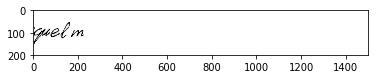

quelm -> eeeee
Batch 90 Loss 13.215615


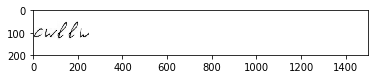

cwllw -> eeeee
Epoch 3
Batch 0 Loss 66.699928
Batch 50 Loss 67.153351
Batch 100 Loss 66.966263


In [0]:
for i in range(0, 100):
  train(i)
  with torch.no_grad():
    test()